
---
<div id="image">
<img src="https://www.imt-atlantique.fr/sites/default/files/logo_mt_0_0.png" WIDTH=280 HEIGHT=280>
</div>
<br>
<center>
<h1>SoundNet: Learning Sound<br>
Representations from Unlabeled Video</h1>
</center>
<br>
<center>

Authors: `ARIAS Camila and IBARRA Kevin`

</center>

---


The purpose of this notebook is to explain how `SoundNet` works (maths, code, and experiments). Soundnet was developed in 2016 in order to use the natural synchronization between pictures and sounds to learn an acoustic representation from a large number of unlabeled videos, it means to get important features of the sound which allow us to depict them. Other studies are focused on features such as spectrograms and MFCC, on another hand,  Soundnet is focused on the natural sounds.

[Scientific article reference](https://arxiv.org/pdf/1610.09001.pdf)  by Yusuf Aytar, Carl Vondrick, Antonio Torralba. NIPS 2016

[SoundNet in Keras](https://github.com/brain-bzh/soundnet_keras) SoundNet, built in Keras with pre-trained 8-layer model.

# Presentation of the problem

There are a lot of works related to object recognition, speech recognition and machine translation using labeled dataset as a reference but it is not the same for natural sounds understanding, due to collect labeled sounds is expensive and ambiguous. To handle the problem with labels for this kind of sounds, the authors capitalize on the natural relation between pictures and sounds in videos using a student-teacher training procedure.

This procedure exploits well-defined models in visual recognition to transfer this knowledge to unlabeled audio.  


## Solution proposal
- An unsupervised deep convolutional network which learns directly from the **raw audio** waveform (it means there are not pre-processing in input data)
- The deep convolutional network to audio is trained by video unlabeled as a bridge.
- Without truth sound labels.


>Another important aspects. 
* Dataset of 2M videos from Flickr.
* To improve the performance in training is necessary to reduce sample rate to 22 kHz and single channel.

          
## Architecture
![sound.jpeg](../TP's/images/sound.jpeg)

SoundNet is a deep convolutional network, layers are described as follow:
    
1. `Fully convolutional network: One dimensional convolutional layer + ReLU activation layer`     
    **Why does it use convolutional layer into sound data?**
    
      Because they are translation invariant reducing the number of parameters and they allow stack layers, useful to detect higher-level concept.
    
2. `Pooling Layers` 
    
    To down-sample variable length inputs. 
    
    

## Math in training

Now it will be explained the maths behind this project. It is important to emphasize that in training phase was used video, but the aim is to recognize sounds. For this reason, in the compiled model videos are not the input. 

The problem has been modeled from a student-teacher perspective. In this case, well-established networks for vision will teach the network for sound to recognize scenes and objects.

The inputs in the model are **raw audio** $x_i \in \mathcal{R}^D$ and **video** $y_i \in \mathcal{R}^{3xTxWxH}$ for each **$i$** in $1<i<N$, where $W,H,T$ are width, height and number of sampled frames in the video, respectively.

During learning the focus is get the probabilities $g_k(y_i)$ from the teacher vision network in order to train the student audio network $f_k(x_i)$, **$k$** enumerates the number of concepts transfered from teacher to student. 

In this way, they have defined a loss function, 
$$L(g_k,f_k)=min_{\theta}\sum_{k=1}^K \sum_{i=1}^N D_{KL}(g_k(y_i)||f_k(x_i;\theta))$$
where $D_{KL}(P||Q) = \sum_{j=1} P_j*log\frac{P_j}{Q_j}$ is the Kullback–Leibler divergence.

That is a measure of how one probability distribution is different from a second. The authors chose KL-divergence
because is differentiable, then it is possible optimize it using back-propagation and stochastic gradient
descent.


## Key aspects of the learning setting

### SOUND CLASSIFICATION
The authors use train SoundNet to classify visual categories but some categories they wish to recognize may not
appear in visual models. To solve this problem they ignore the output of the network and use a hidden representation as a strategy to attach semantic meaning to sound. Using this internal representation they train a linear **SVM** classifier considering a small number of labels about interest topics.

>Another parameters from classifier. 
* Optimizer: Adam (learning rate of 0.001 and momentum term of 0.9).
* Multi-class classification: one vs. all.
* Margin regularization: cross-validation.
* Robustness: Standard data augmentation.

# IMPLEMENTATION

### Code: model pre-trained

In this section will be explained the code and how it works. 

The code given by the professor staff corresponds to [SoundNet](https://github.com/brain-bzh/soundnet_keras) built in Keras with a pre-trained **8-layer model** originally obtained in Torch 7.

>Model parameters were obtained after 100.000 iterations (1 day GPU processing) using 2M unlabeled videos and 140.000 videos to validation. 

![schema.png](../TP's/images/schema.png)

>This is a system representation for the neural network to audio classification trained with a VGG16 (401 categories) as supervisor.

To start is necessary obtain a model with all parameters pre-trained (weights, biases, etc.). 

In [1]:
# -*- coding: utf-8 -*-
from keras.layers import BatchNormalization, Activation, Conv1D, MaxPooling1D, ZeroPadding1D, InputLayer
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import librosa #audio library

Using TensorFlow backend.
/homes/d18arias/.local/lib/python3.6/site-packages/numba/errors.py:104: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


# The configuration of the layers 

<img src="../TP's/images/layers.png" width="600">

With `build_model` is built SoundNet according to the structure defined by the authors. This model has as input the audio raw waveform and two outputs: scenes and objects distribution.

In [2]:
def build_model():
    """
    Builds up the SoundNet model and loads the weights from a given model file (8-layer model is stored at models/sound8.npy).
    :return: The model built according to architecture and weights pre-stablished      
    """
    model_weights = np.load('../soundnet_keras-master/models/sound8.npy',encoding = 'latin1').item()
    model = Sequential()
    #Input layer: audio raw waveform (1,length_audio,1)
    model.add(InputLayer(batch_input_shape=(1, None, 1)))

    filter_parameters = [{'name': 'conv1', 'num_filters': 16, 'padding': 32,
                          'kernel_size': 64, 'conv_strides': 2,
                          'pool_size': 8, 'pool_strides': 8}, #pool1

                         {'name': 'conv2', 'num_filters': 32, 'padding': 16,
                          'kernel_size': 32, 'conv_strides': 2,
                          'pool_size': 8, 'pool_strides': 8}, #pool2

                         {'name': 'conv3', 'num_filters': 64, 'padding': 8,
                          'kernel_size': 16, 'conv_strides': 2},

                         {'name': 'conv4', 'num_filters': 128, 'padding': 4,
                          'kernel_size': 8, 'conv_strides': 2},

                         {'name': 'conv5', 'num_filters': 256, 'padding': 2,
                          'kernel_size': 4, 'conv_strides': 2,
                          'pool_size': 4, 'pool_strides': 4}, #pool5

                         {'name': 'conv6', 'num_filters': 512, 'padding': 2,
                          'kernel_size': 4, 'conv_strides': 2},

                         {'name': 'conv7', 'num_filters': 1024, 'padding': 2,
                          'kernel_size': 4, 'conv_strides': 2},

                         {'name': 'conv8_2', 'num_filters': 401, 'padding': 0,
                          'kernel_size': 8, 'conv_strides': 2},#output: VGG 401 classes
                         ]

    for x in filter_parameters:
        #for each [zero_padding - conv - batchNormalization - relu]
        model.add(ZeroPadding1D(padding=x['padding']))
        model.add(Conv1D(x['num_filters'],
                         kernel_size=x['kernel_size'],
                         strides=x['conv_strides'],
                         padding='valid'))
        weights = model_weights[x['name']]['weights'].reshape(model.layers[-1].get_weights()[0].shape)
        biases = model_weights[x['name']]['biases']

        model.layers[-1].set_weights([weights, biases])  #set weights in convolutional layer

        if 'conv8' not in x['name']:
            gamma = model_weights[x['name']]['gamma']
            beta = model_weights[x['name']]['beta']
            mean = model_weights[x['name']]['mean']
            var = model_weights[x['name']]['var']

            
            model.add(BatchNormalization())
            model.layers[-1].set_weights([gamma, beta, mean, var]) #set weights in batchNormalization
            model.add(Activation('relu'))
            
        if 'pool_size' in x:
            #add 3 pooling layers
            model.add(MaxPooling1D(pool_size=x['pool_size'],
                                   strides=x['pool_strides'],
                                   padding='valid'))

    return model


## Audio preprocessing

In [3]:
def preprocess(audio):
    audio *= 256.0  # SoundNet requires an input range between -256 and 256
    # reshaping the audio data, in this way it fits into the graph (batch_size, num_samples, num_filter_channels)
    audio = np.reshape(audio, (1, -1, 1))
    return audio


def load_audio(audio_file):
    sample_rate = 22050  # SoundNet works on monophonic-audio files with sample rate of 22050.
    audio, sr = librosa.load(audio_file, dtype='float32', sr=22050, mono=True) #load audio
    audio = preprocess(audio) # pre-process using SoundNet parameters
    return audio

## Construction of the model

In [4]:
from keras.utils import plot_model

#Review of the model and architecture parameters
model = build_model()
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding1d_1 (ZeroPaddin (1, None, 1)              0         
_________________________________________________________________
conv1d_1 (Conv1D)            (1, None, 16)             1040      
_________________________________________________________________
batch_normalization_1 (Batch (1, None, 16)             64        
_________________________________________________________________
activation_1 (Activation)    (1, None, 16)             0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (1, None, 16)             0         
_________________________________________________________________
zero_padding1d_2 (ZeroPaddin (1, None, 16)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (1, None, 32)             16416     
__________

# 1. First experiments

At this moment, the SoundNet model is already built. 

Next function is defined to obtain the output tags:

In [5]:
f = open('../soundnet_keras-master/categories/categories_places2.txt', 'r') 
categories = f.read().split('\n')

In [6]:
def predictions_to_scenes(prediction):
    scenes = []
    for p in range(prediction.shape[1]):
        scenes.append(categories[np.argmax(prediction[0, p, :])])
    return scenes


### Input - Output SoundNet

Which is the prediction?

In [7]:
# let's load an audio file
audiot,sr = librosa.load('../soundnet_keras-master/railroad_audio.wav', 
                         dtype='float32', sr=22050, mono=True) #load audio

#library to listen sound
import IPython.display as ipd
ipd.Audio(audiot, rate=sr) # load 

#sound like a railroad or not?

In [8]:
# Function to built the model and predict scenes related with a given audio 
def predict_scene_from_audio_file(audio_file):
    model = build_model()
    audio = load_audio(audio_file)
    return model.predict(audio)

# Use previous function to predict and show scenes in the audio
prediction = predict_scene_from_audio_file('../soundnet_keras-master/railroad_audio.wav')
print("output model shape", prediction.shape)

output model shape (1, 4, 401)


### We can see the different ways in which the classes were activated, in a more detailed manner:

In [9]:
def findMax(vector): #find 3 classes max
    maximus = []
    for i in range(3):
        index = np.argmax(vector)
        f = [index, max(vector)]
        vector[index] = 0 
        maximus.append(f)
    return maximus   

In [10]:
def putText(datos,x):
    f = findMax(datos)
    text = "Prediction " + str(x) + ": "
    for i in f:
        text = text +" - "+ categories[i[0]]
    print(text)

In [11]:
 def plot_scenes(pred,title):
    plt.figure(figsize=(16,8))
    for i in range(pred.shape[1]):# number of prediction vectors
        datos = (pred[0,i,:] > 0)* pred[0,i,:] #find classes 
        label='Window no: '+ str(i)
        plt.bar(np.arange(0,pred.shape[2]),datos,label = label) # it draws the histogram for each window
        m = np.argmax(datos)
        plt.text(m,max(datos)-(0.01),'Scene out: '+ str(i) +categories[m])   
        putText(datos,i)

    plt.legend()   
    plt.title(title)
    plt.xlabel('Scenes')

Prediction 0:  - /r/railroad_track - /t/train_station/platform - /t/train_railway
Prediction 1:  - /r/railroad_track - /t/train_station/platform - /t/train_railway
Prediction 2:  - /r/railroad_track - /t/train_station/platform - /t/train_railway
Prediction 3:  - /t/train_station/platform - /r/railroad_track - /t/train_railway


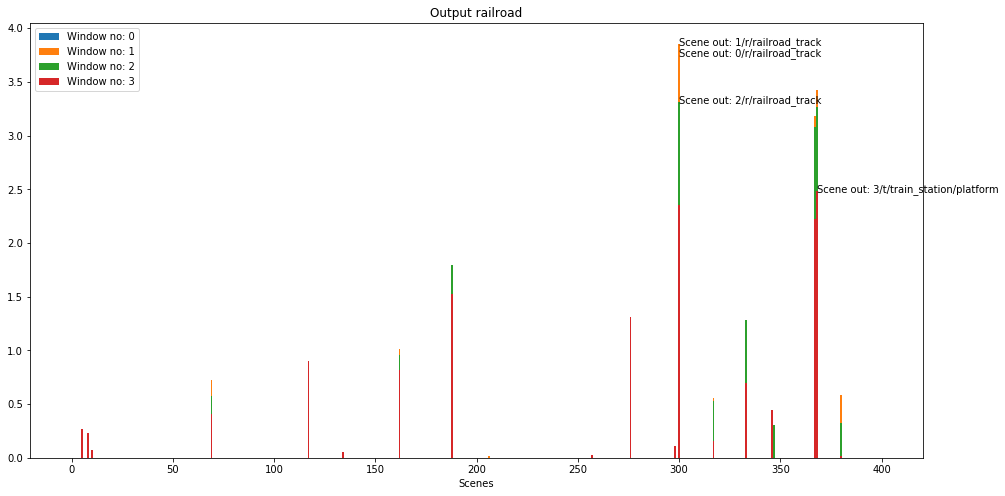

In [12]:
# Use previous function to show histogram in this first audio
plot_scenes(prediction,'Output railroad')

In the figure above is possible to see how are activated the output-vectors on each window for the same audio, it allows us to detect some values (scenes) who are higher probability to appear in analyzed audio, in this case, the audio is a recording of a railroad, the first prediction found by SoundNet is a train station, but after the system can recognize the railroad.

### Experiment with another audio: school yard

In [13]:
# Repeat the process to obtain a new prediction
prediction2 = predict_scene_from_audio_file('../soundnet_keras-master/school.wav')
print("output model shape", prediction2.shape) #output model 


output model shape (1, 2, 401)


Prediction 0:  - /p/playground - /s/soccer_field - /a/amusement_park
Prediction 1:  - /p/playground - /s/soccer_field - /b/baseball_field


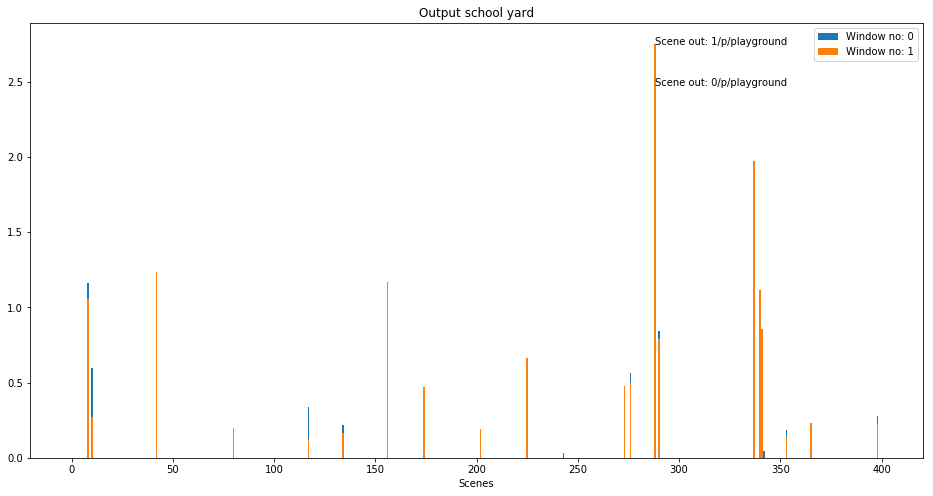

In [14]:
plot_scenes(prediction2,'Output school yard')

In the figure above is possible to see the vector of activations obtained as the prediction for another sound, this one has fewer samples, for this reason, the prediction has just 2 vectors, fewer than *railroad audio*. For this raw audio the two prediction vectors are similar, just change the third most probable scene from *amusement park* to *baseball field*.  

> # Size minimum
> The number of prediction vectors (output-size) depends on the size of the input. It means input must have a minimum size to allow the model predict some output. In the next lines, we try to find this frontier.

In [15]:
# Use previous function to predict and show scenes in the audio
prediction = predict_scene_from_audio_file('../soundnet_keras-master/railroad_audio.wav')
print("Output model shape: ", prediction.shape)

output model shape (1, 4, 401)


# ESC -50 Dataset 

The dataset ESC-50 is a collection of 2000 short (5 seconds) recordings of environmental sounds from equally balanced 50 categories selected from 5 major groups (animals, natural soundscapes, human non-speech sounds, interior/domestic sounds, and exterior/urban noises).

In order to evaluate the model behavior we use the dataset **ESC-10**. It is a subset of ESC-50 which consists of 10 classes (dog bark, rain, sea waves, baby cry, clock tic, person sneeze, helicopter, chainsaw, rooster, and fire cracking).


In [16]:
import pandas as pd
test = pd.read_csv('../ESC-50-master/meta/esc50.csv',sep=',')
test.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [17]:
#only 10 classes
esc10 = test[ test['esc10'] == True]
print(esc10[:5]) #first 5 elements

             filename  fold  target        category  esc10  src_file take
0    1-100032-A-0.wav     1       0             dog   True    100032    A
14   1-110389-A-0.wav     1       0             dog   True    110389    A
24  1-116765-A-41.wav     1      41        chainsaw   True    116765    A
54   1-17150-A-12.wav     1      12  crackling_fire   True     17150    A
55  1-172649-A-40.wav     1      40      helicopter   True    172649    A


In [18]:
data = [] #load the audiofiles
list_target = esc10['target'] #list of targets in dataset ESC10
list_category = esc10['category'] #list of categories (escenes) in dataset ESC10

#loop to load audiofiles
for file_name in list(esc10['filename']):
    audio = load_audio('../ESC-50-master/audio/'+file_name)
    data.append(audio) 

In [19]:
print("Total size loaded data: ",len(data),len(list_target),len(list_category)) #load correctly
print("Example: ",list_target[0],list_category[0]) #load correctly

400 400 400
0 dog


### Test with Esc10


In [20]:
datos = np.asarray([data[155]]).reshape(1,-1,1) # failure due to the size
print("Data shape: ",datos.shape)

(1, 110250, 1)


> **Compilation error**: the audio has a duration of 5s (110250 samples / 22050 samples per second). The model does not have the minimum number of required samples and is reflected in the Keras kernel. It turns off because of this error.

In [21]:
#p = model.predict(datos) #----------- error (last layer - output)
#print(p.shape)           #----------- error

A new raw audio with three(3) times concatenate single audio is enough in terms of samples for the model.

In [22]:
#For this test we use "audio 1-172649-b-40 helicopter" audio number 5 in datos
datos = np.asarray([data[5],data[5],data[5]]).reshape(1,-1,1)
print("Input shape: ", datos.shape)

input shape (1, 330750, 1)


output shape (1, 2, 401)
Prediction 0:  - /p/parking_lot - /r/runway - /r/raceway
Prediction 1:  - /r/runway - /p/parking_lot - /r/raceway


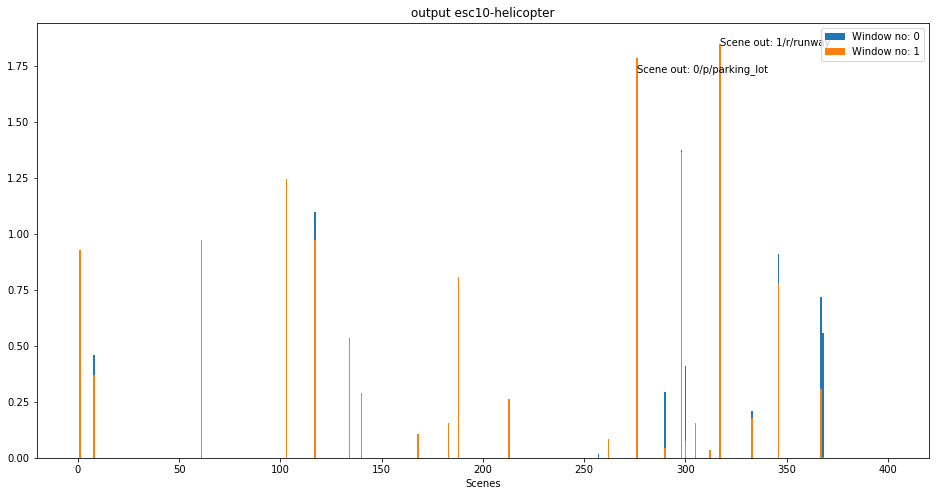

In [23]:
p = model.predict(datos) #- > Three times data: enough samples for the model
print("Output shape: ",p.shape)
plot_scenes(p,'output esc10-helicopter')

# 2. Own experiments
---
## High level features and sound classifier 
---
> If we want to use SoundNet as input-output model we must use audios with duration greater than 5s, however is possible to obtain information about internal representation from any audio.
1. To find features in hidden layers in order to transfer learning, that will be presented below via TSNE graphs. 
2. To design and to train a new classifier using as input the output of a hidden layer (pool5) which has been chosen due to the lower number of parameter in the network.






# How to obtain the hidden representation

It is possible to obtain internal representation using `Keras: backend`

The method is as follow, where `number_layer` is the desired-hidden layer.
```python
get_layer_output = K.function([model.layers[0].input],
                               [model.layers[number_layer].output])
```

In [24]:
from keras import backend as K

# return the list of activations as tensors for an specific layer in the model 
def getActivations(data,number_layer):
    intermediate_tensor = []
    #get Hidden Representation function
    get_layer_output = K.function([model.layers[0].input],
                                  [model.layers[number_layer].output])
    #just for information
    ex = get_layer_output([data[155]])[0]
    print('Dimension layer {}: {}'.format(number_layer,ex.shape))
    
    for audio in data:
        #get Hidden Representation       
        layer_output = get_layer_output([audio])[0] # multidimensional vector
        tensor = layer_output.reshape(1,-1) # change vector shape to 1 (tensor)
        intermediate_tensor.append(tensor[0]) # list of tensor activations for each object in Esc10
    return intermediate_tensor

# How to visualize multidimensional data

Below, it will be submitted a data dimension reduction to visualize the multidimensional data easily and quickly. 

In [25]:
from sklearn.manifold import TSNE
from time import time #control time

#produce the visualisation of hidden representation for a hidden layer given an intermediate tensor and a list of targets
def toTSNE(intermediate_tensor, target,number_layer,ax):
    t0 = time()    
    tsne = TSNE(n_components=2, random_state=0) #define dimension of the graph
    #get activation from data and obtain tsne representation
    intermediates_tsne = tsne.fit_transform(intermediate_tensor)
    
    ax.scatter(x = intermediates_tsne[:,0], y=intermediates_tsne[:,1],c = target, alpha = 0.7,cmap = plt.cm.Spectral)  
    ax.title("TSNE layer %i (time %.2fs)" % (number_layer,time() - t0))
    ax.colorbar()

### How does the output look like in layer Pool5?

In [26]:
activations22 = getActivations(data,22) #get activation tensor for the 22nd layer in the model (pool5)

Dimension layer 22: (1, 13, 256)


In [27]:
print("Total tensors: ", len(activations22))
print("Size tensor: ", len(activations22[0]))

Total tensors:  400
Size tensor:  3328


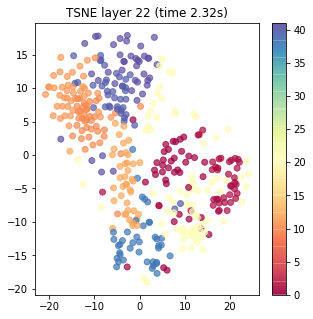

In [28]:
#Visualisation output hidden layer pool 5 (22nd layer in model)
fig = plt.figure(figsize=(5,5))
toTSNE(activations22,list_target,22,plt) # use a function defined before to make the graph 

In this figure we can see a reduction of dimension for this data using TSNE (an algorithm for low-dimension visualization), it allows to note how the data with similar characteristics are organized in some regions, it is because of the processing made by the SoundNet. 

# Neuronal networks: find relationships


Dimension layer 0: (1, 110314, 1)
Dimension layer 4: (1, 6890, 16)
Dimension layer 9: (1, 430, 32)
Dimension layer 15: (1, 109, 128)
Dimension layer 22: (1, 13, 256)
Dimension layer 28: (1, 4, 1024)


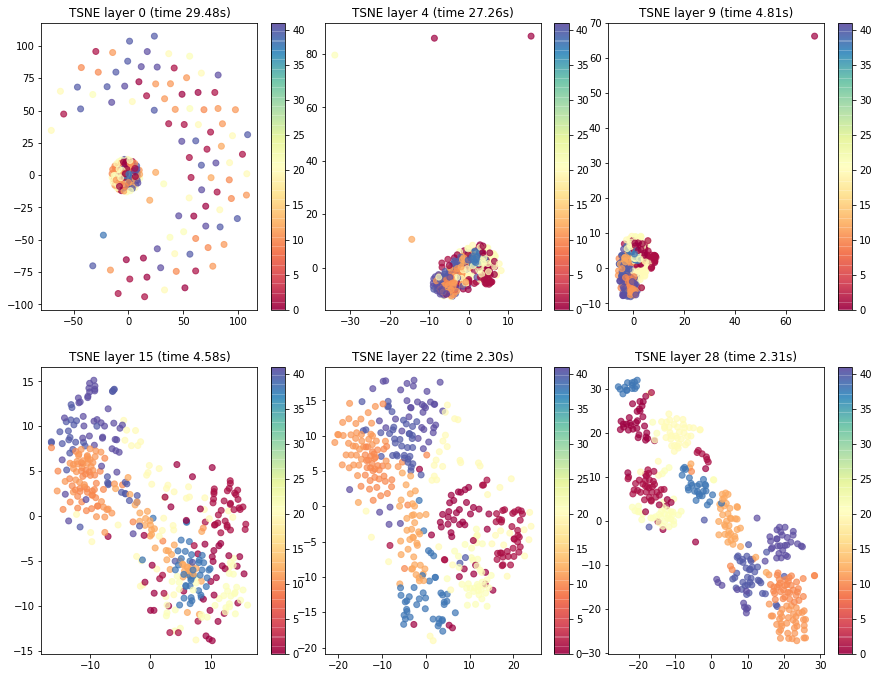

In [50]:
#%matplotlib inline
layers = [0,4,9,15,22,28] # List of important hidden layers

fig = plt.figure(figsize=(15,12))
# Loop to make the graph from each desired layer
for c,i in enumerate(layers):
    ax = fig.add_subplot(2,3,c+1)
    activations = getActivations(data,i)
    toTSNE(activations,list_target,i,plt)
plt.subplots_adjust(bottom=0.15, wspace=0.05)


In this graph is possible to look how the data is recognized and organized by the neural network proposed, which allows making a faster visualization each time, due to sounds share features in the internal representation with other sounds in the same target.

In the first position is the representation of raw audio, it is evident that there is no particular relation between elements of the same class, even after 31 seconds of analysis. Second and third figures allow to visualize first steps in audio recognition but are not enough to show clear differences between classes. Fourth and fifth figures (layers 15 and 22 respectively) show better results, now there are identifiable regions (in 2D space) for some classes, in one the time of analysis es lower than 5 seconds, while on the other is lower to 3 seconds, that is because of reduction in the number of parameter in the internal representation of the sound. The last figure shows a better classification before the last layer, in this, the regions for each class is well established, the time of analysis is a little bit higher because of the number of parameters in the representation has increased.


# Classifier from hidden layers

In this section, will be shown the process of training for two type of audio classifiers which exploit the internal representation obtained in the 22nd layer of SoundNet in order to classifier other types of sounds.

In [30]:
#obtain vector layer 22 INPUT
x = np.asarray(getActivations(data,22)) #Transfer learning
print('Dataset input shape', x.shape)
y = np.asarray(list_target)
print('Target list shape',y.shape)

Dimension layer 22: (1, 13, 256)
Dataset input shape (400, 3328)
Target list shape (400,)


### Preprocessing of dataset

In order to convert the class vectors to binary class matrices representation, it is necessary to change the range of the tags, from 0 to 9. 

In [31]:
#obtain original values
toClass = {} #dictionary to translate values of classes
toCategory = {} #dictionary with new values of categories
names = np.asarray(list_category) #array with names of categories
i = 0
# loop to change all target from Esc50 values to 0-9 range
for position,target in enumerate(y):
    if target not in toClass:        
        toClass[target] = i #dictionary classes
        toCategory[i] = names[position] #dictionary categories
        i += 1

print("Dictionary of classes: ",toClass)
print("Values representation: ",toCategory)

Dictionary of classes:  {0: 0, 41: 1, 12: 2, 40: 3, 10: 4, 20: 5, 38: 6, 21: 7, 1: 8, 11: 9}
Values representation:  {0: 'dog', 1: 'chainsaw', 2: 'crackling_fire', 3: 'helicopter', 4: 'rain', 5: 'crying_baby', 6: 'clock_tick', 7: 'sneezing', 8: 'rooster', 9: 'sea_waves'}


In [32]:
#change vector of classes
Y = []
for i in y:
    Y.append(toClass[i])
Y = np.asarray(Y)
print("Elem. 100: Class before:", y[100], " Class after:", Y[100])

Elem. 100: Class before: 38  Class after: 6


### Train and test dataset

In [33]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
num_classes = 10

#Split data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.2, random_state = 25)
z_train = to_categorical(y_train, num_classes) # convert class vectors to binary class matrices
z_test = to_categorical(y_test, num_classes)
print("Binary representation of the first tag: ",z_train[0])

Binary representation of the first tag:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


# Single-layer perceptron (classifier with Softmax)

Taking advantage of the SoundNet layer is possible implement a simple neural network and wait for good results. Down below, is submitted the process of training and test.

In [34]:
#model classifier
from keras.models import Sequential
from keras.layers import Dense

#for a single layer perceptron is necessary just a softmax layer
classifier = Sequential()
classifier.add(Dense(num_classes, activation='softmax',input_shape=(3328,)))
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                33290     
Total params: 33,290
Trainable params: 33,290
Non-trainable params: 0
_________________________________________________________________


In [35]:
from keras.optimizers import RMSprop,Adam
#Define optimization function and compile the model
classifier.compile(loss='categorical_crossentropy', optimizer=Adam(),metrics=['accuracy'])

In [36]:
batch_size =64
epochs = 20
#fit classifier
hist_classifier = classifier.fit(x_train,z_train, validation_data=(x_test,z_test), epochs=epochs,batch_size=batch_size)

Train on 320 samples, validate on 80 samples
Epoch 1/20
320/320 [==============================] - 1s 2ms/step - loss: 2.0391 - acc: 0.2687 - val_loss: 1.5610 - val_acc: 0.5375
Epoch 2/20
320/320 [==============================] - 0s 41us/step - loss: 1.1630 - acc: 0.6969 - val_loss: 1.0225 - val_acc: 0.7375
Epoch 3/20
320/320 [==============================] - 0s 33us/step - loss: 0.7186 - acc: 0.8625 - val_loss: 0.8049 - val_acc: 0.7500
Epoch 4/20
320/320 [==============================] - 0s 46us/step - loss: 0.4989 - acc: 0.9094 - val_loss: 0.6815 - val_acc: 0.7875
Epoch 5/20
320/320 [==============================] - 0s 44us/step - loss: 0.3613 - acc: 0.9250 - val_loss: 0.5854 - val_acc: 0.8000
Epoch 6/20
320/320 [==============================] - 0s 48us/step - loss: 0.2789 - acc: 0.9500 - val_loss: 0.5202 - val_acc: 0.8000
Epoch 7/20
320/320 [==============================] - 0s 44us/step - loss: 0.2211 - acc: 0.9562 - val_loss: 0.4957 - val_acc: 0.8375
Epoch 8/20
320/320 [=====

In [37]:
# list all data in history
def evaluate_model(model,history,title):
    print(history.history.keys())
    #Visualize history (loss vs epochs)
    plt.figure()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model acc '+ title)
    plt.ylabel('acc')  
    plt.xlabel('epochs')
    plt.legend(['train','val'], loc='upper left')
    plt.show()

    score = model.evaluate(x_test, z_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


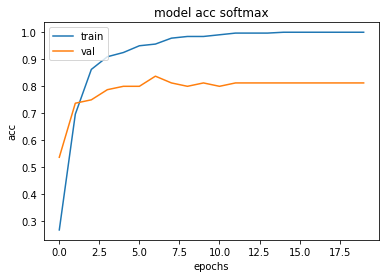

Test loss: 0.43525474071502684
Test accuracy: 0.8125


In [38]:
evaluate_model(classifier,hist_classifier,'softmax')

In this figure is shown the evolution of accuracy thought the epochs, the orange-line related with trained notices that there is not overfitting in the process. The accuracy obtained is 81.25% lower than the offered by the authors in their article, we consider it is because they use some high-level strategies like data augmentation for training and test, as well as a recurrent change in learning rate along training.

# Linear SVM
In this subsection is submitted a concise explanation about the implementation of the same classifier used by the authors, a Linear Support Vector Machine classifier (Linear SVM).

In [39]:
from sklearn import svm
# model definition
lin_clf = svm.SVC(kernel='linear')
# fit the model using same data for training
history_clf = lin_clf.fit(x_train, y_train)

In [40]:
# prediction for all data test
y_pred_svm = lin_clf.predict(x_test)
print(y_pred_svm,y_pred_svm.shape)

[2 8 4 0 1 4 5 9 7 5 0 7 9 1 7 6 2 4 9 1 6 8 3 2 5 8 9 5 6 8 0 3 5 7 3 8 5
 2 2 3 5 4 7 0 9 8 3 3 8 9 5 6 0 6 4 6 7 9 1 5 4 9 2 5 6 2 9 2 3 5 1 3 3 5
 4 9 2 7 7 8] (80,)


In [41]:
from sklearn.metrics import accuracy_score
# final accuracy, comparing 
accuracy_score(y_test,y_pred_svm)

0.85

# Comparison

In [42]:
from sklearn.metrics import confusion_matrix
import itertools

class_names = [toCategory[i] for i in range(10)]

#function to plot confusion matrix, for a model and data given
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [43]:
# Compute confusion matrix
def visualize_confusion_matrix(y_test, y_pred):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()



In [44]:
def toPredict(model,x_test): # to obtain prediction vector
    z_pred = model.predict(x_test,64,verbose=1)
    return np.argmax(z_pred,axis=1)
y_pred_c = toPredict(classifier,x_test)

80/80 [==============================] - 0s 2ms/step


## Single-layer perceptron (classifier with Softmax)

acc 0.8125
Normalized confusion matrix


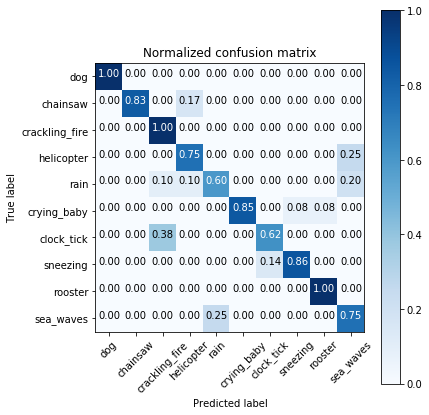

In [45]:
print("acc {}".format(classifier.evaluate(x_test, z_test, verbose=0)[1]))
visualize_confusion_matrix(y_test, y_pred_c)

## Linear SVM

acc 0.85
Normalized confusion matrix


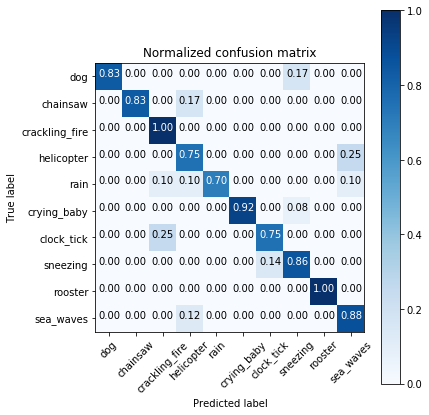

In [46]:
print("acc {}".format(accuracy_score(y_test,y_pred_svm)))
visualize_confusion_matrix(y_test, y_pred_svm)

In conclusion, the performance presented by Single-layer Perceptron and Linear SVM in terms of accuracy is similar, nevertheless, the SVM presents a better accuracy that may be due to the data representation, in which is possible to make clusters. In order to get the values of accuracy (92.2%) presented by the authors is necessary to apply other strategies (data augmentation and change in learning rate) but this is not the goal of this document.  